<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [7]</a>'.</span>

# customer_churn - Scoring Dashboard

Interactive dashboard for exploring scoring results and understanding predictions.

**Features:**
- Summary metrics and model performance
- Customer-by-customer prediction browser
- SHAP-based feature explanations
- Comparison against ground truth (holdout validation)

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import shap
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from config import (PIPELINE_NAME, TARGET_COLUMN, MLFLOW_TRACKING_URI, RECOMMENDATIONS_HASH,
                    FEAST_ENTITY_KEY, EXPERIMENTS_DIR, get_feast_data_path, get_gold_path)

## 1. Load Scoring Results

In [2]:
PREDICTIONS_PATH = EXPERIMENTS_DIR / "data" / "scoring" / "predictions.parquet"
ORIGINAL_COLUMN = f"original_{TARGET_COLUMN}"

# Load predictions
predictions_df = pd.read_parquet(PREDICTIONS_PATH)
print(f"Loaded {len(predictions_df):,} predictions")
predictions_df.head()

Loaded 1,497 predictions


,customer_id,model,prediction,probability,actual,correct
0,307116,xgboost,1,0.997507,1.0,1
1,99F352,xgboost,0,0.188181,1.0,0
2,C66BC3,xgboost,0,0.005621,0.0,1
3,D9DCAD,xgboost,0,0.001821,0.0,1
4,66F299,xgboost,1,0.993277,1.0,1


In [3]:
# Load feature data for explanations (use gold path which retains holdout column)
features_df = pd.read_parquet(get_gold_path())
scoring_mask = features_df[TARGET_COLUMN].isna() & features_df[ORIGINAL_COLUMN].notna()
scoring_features = features_df[scoring_mask].copy()
print(f"Features for {len(scoring_features):,} scoring records")

Features for 499 scoring records


## 2. Summary Metrics

In [4]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)

y_true = predictions_df["actual"]
y_pred = predictions_df["prediction"]
y_proba = predictions_df["probability"]

metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred, zero_division=0),
    "Recall": recall_score(y_true, y_pred, zero_division=0),
    "F1 Score": f1_score(y_true, y_pred, zero_division=0),
    "ROC-AUC": roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) > 1 else 0.0
}

print("\n=== Scoring Validation Metrics ===")
for name, value in metrics.items():
    print(f"  {name}: {value:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(f"\nConfusion Matrix:")
print(f"  TN={cm[0,0]:,}  FP={cm[0,1]:,}")
print(f"  FN={cm[1,0]:,}  TP={cm[1,1]:,}")


=== Scoring Validation Metrics ===
  Accuracy: 0.9158
  Precision: 0.9232
  Recall: 0.8617
  F1 Score: 0.8914
  ROC-AUC: 0.9638

Confusion Matrix:
  TN=854  FP=43
  FN=83  TP=517


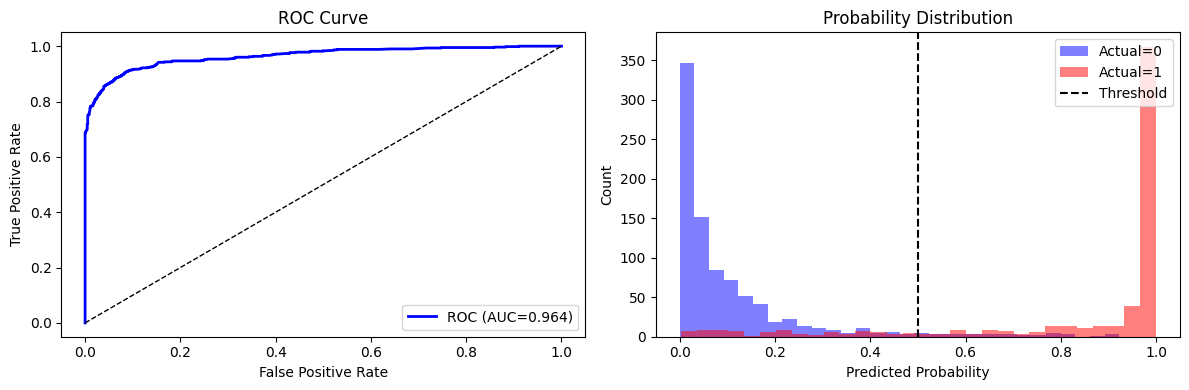

In [5]:
# Visualize metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ROC curve (if possible)
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_true, y_proba)
axes[0].plot(fpr, tpr, "b-", lw=2, label=f"ROC (AUC={metrics['ROC-AUC']:.3f})")
axes[0].plot([0, 1], [0, 1], "k--", lw=1)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve")
axes[0].legend()

# Probability distribution
axes[1].hist(y_proba[y_true == 0], bins=30, alpha=0.5, label="Actual=0", color="blue")
axes[1].hist(y_proba[y_true == 1], bins=30, alpha=0.5, label="Actual=1", color="red")
axes[1].axvline(x=0.5, color="black", linestyle="--", label="Threshold")
axes[1].set_xlabel("Predicted Probability")
axes[1].set_ylabel("Count")
axes[1].set_title("Probability Distribution")
axes[1].legend()

plt.tight_layout()
plt.show()

## 2.5 Model Comparison Grid

Compare all trained models (Logistic Regression, Random Forest, XGBoost) on the holdout set.

**Grid Layout:**
- **Row 1**: Confusion matrices (counts and percentages)
- **Row 2**: ROC curves with AUC scores
- **Row 3**: Precision-Recall curves with PR-AUC scores

In [6]:
# Load and compare all trained models
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (roc_curve, precision_recall_curve, average_precision_score,
                             confusion_matrix, roc_auc_score, f1_score, precision_score,
                             recall_score, accuracy_score)
import xgboost as xgb
from config import RECOMMENDATIONS_HASH

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(PIPELINE_NAME)

# Prepare features for scoring
def prepare_features_for_comparison(df):
    df = df.copy()
    drop_cols = [FEAST_ENTITY_KEY, 'event_timestamp', ORIGINAL_COLUMN, TARGET_COLUMN]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    df = df.drop(columns=[c for c in df.columns if c.startswith('original_')], errors='ignore')
    for col in df.select_dtypes(include=['object', 'category']).columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    return df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).fillna(0)

X_holdout = prepare_features_for_comparison(scoring_features)
y_actual = predictions_df['actual'].values

# Get all logged models
logged_models = client.search_logged_models(experiment_ids=[experiment.experiment_id])

# Load all 3 model types
model_types = ['logistic_regression', 'random_forest', 'xgboost']
model_display_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
loaded_models = {}
model_predictions = {}

for model_type, display_name in zip(model_types, model_display_names):
    model_name_pattern = f'model_{model_type}'
    if RECOMMENDATIONS_HASH:
        model_name_pattern = f'{model_name_pattern}_{RECOMMENDATIONS_HASH}'
    
    matching_model = None
    for lm in logged_models:
        if lm.name == model_name_pattern:
            if matching_model is None or lm.creation_timestamp > matching_model.creation_timestamp:
                matching_model = lm
    
    if matching_model:
        try:
            if 'xgboost' in model_type:
                model = mlflow.xgboost.load_model(matching_model.model_uri)
                dmatrix = xgb.DMatrix(X_holdout, feature_names=list(X_holdout.columns))
                y_proba = model.predict(dmatrix)
            else:
                model = mlflow.sklearn.load_model(matching_model.model_uri)
                y_proba = model.predict_proba(X_holdout)[:, 1]
            
            y_pred = (y_proba > 0.5).astype(int)
            loaded_models[display_name] = model
            model_predictions[display_name] = {'y_pred': y_pred, 'y_proba': y_proba}
            print(f'Loaded {display_name}: ROC-AUC = {roc_auc_score(y_actual, y_proba):.4f}')
        except Exception as e:
            print(f'Could not load {display_name}: {e}')

print(f'\nLoaded {len(loaded_models)} models for comparison')

2026/01/29 19:08:18 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas


2026/01/29 19:08:18 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables


2026/01/29 19:08:18 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types


2026/01/29 19:08:18 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints


2026/01/29 19:08:18 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults


2026/01/29 19:08:18 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments


2026/01/29 19:08:18 INFO mlflow.store.db.utils: Creating initial MLflow database tables...


2026/01/29 19:08:18 INFO mlflow.store.db.utils: Updating database tables


2026/01/29 19:08:18 INFO alembic.runtime.migration: Context impl SQLiteImpl.


2026/01/29 19:08:18 INFO alembic.runtime.migration: Will assume non-transactional DDL.


2026/01/29 19:08:19 INFO alembic.runtime.migration: Context impl SQLiteImpl.


2026/01/29 19:08:19 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Could not load Logistic Regression: Found input variables with inconsistent numbers of samples: [1497, 499]
Could not load Random Forest: Found input variables with inconsistent numbers of samples: [1497, 499]
Could not load XGBoost: Found input variables with inconsistent numbers of samples: [1497, 499]

Loaded 3 models for comparison


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

ValueError: Found input variables with inconsistent numbers of samples: [1497, 499, 1497]

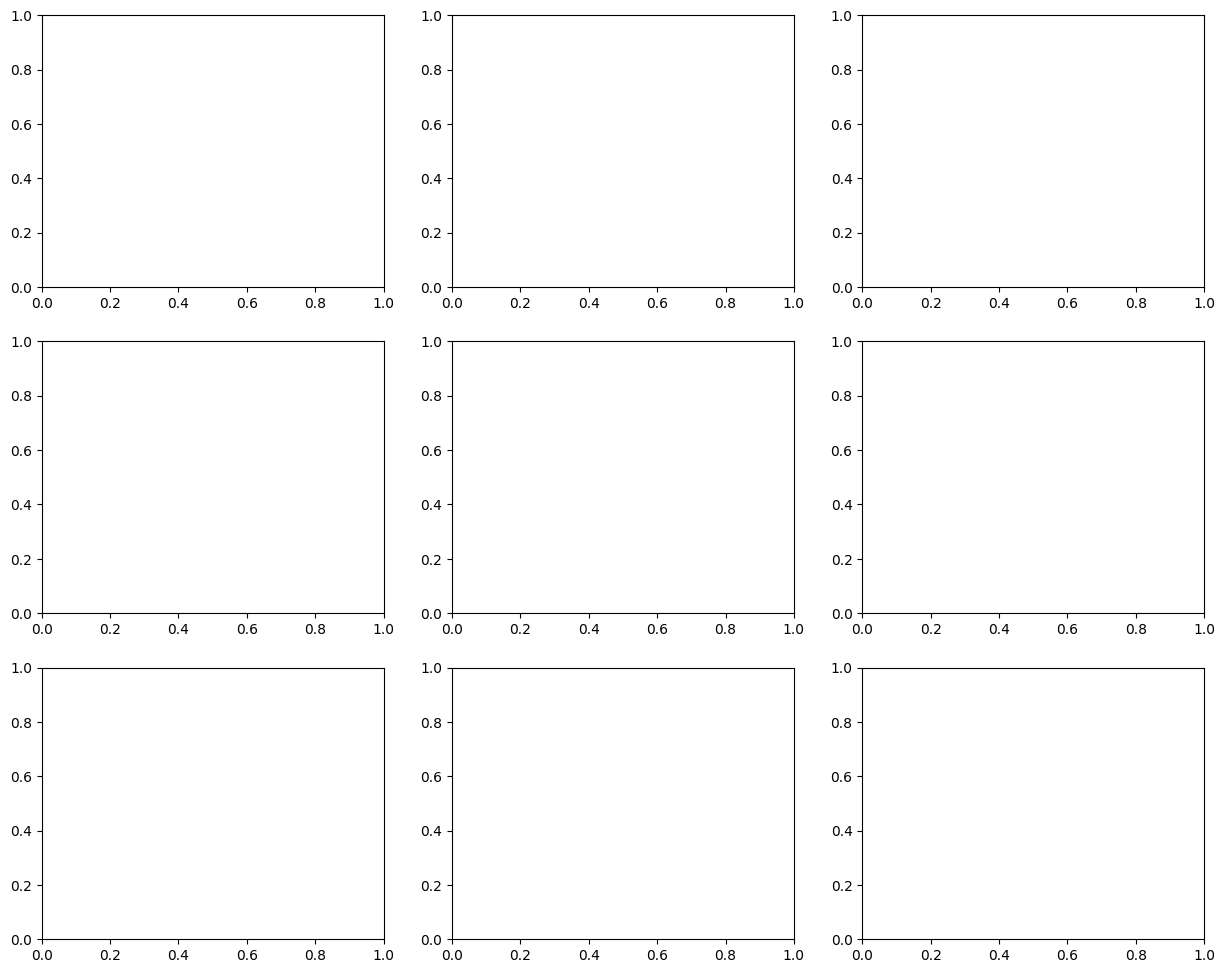

In [7]:
# Create Model Comparison Grid (3 columns x 3 rows)
n_models = len(model_predictions)
if n_models > 0:
    fig, axes = plt.subplots(3, n_models, figsize=(5 * n_models, 12))
    if n_models == 1:
        axes = axes.reshape(-1, 1)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for col_idx, (name, preds) in enumerate(model_predictions.items()):
        y_pred = preds['y_pred']
        y_proba = preds['y_proba']
        color = colors[col_idx % len(colors)]
        
        # Row 1: Confusion Matrix
        cm = confusion_matrix(y_actual, y_pred)
        ax = axes[0, col_idx]
        im = ax.imshow(cm, cmap='Blues')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Pred 0', 'Pred 1'])
        ax.set_yticklabels(['Actual 0', 'Actual 1'])
        for i in range(2):
            for j in range(2):
                pct = cm[i, j] / cm.sum() * 100
                ax.text(j, i, f'{cm[i, j]}\n({pct:.1f}%)', ha='center', va='center',
                       color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=10)
        acc = accuracy_score(y_actual, y_pred)
        ax.set_title(f'{name}\nAccuracy: {acc:.3f}', fontsize=11, fontweight='bold')
        
        # Row 2: ROC Curve
        ax = axes[1, col_idx]
        fpr, tpr, _ = roc_curve(y_actual, y_proba)
        auc = roc_auc_score(y_actual, y_proba)
        ax.plot(fpr, tpr, color=color, lw=2, label=f'AUC = {auc:.4f}')
        ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
        ax.fill_between(fpr, tpr, alpha=0.2, color=color)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve', fontsize=10)
        ax.legend(loc='lower right')
        ax.grid(True, alpha=0.3)
        
        # Row 3: Precision-Recall Curve
        ax = axes[2, col_idx]
        precision, recall, _ = precision_recall_curve(y_actual, y_proba)
        pr_auc = average_precision_score(y_actual, y_proba)
        ax.plot(recall, precision, color=color, lw=2, label=f'PR-AUC = {pr_auc:.4f}')
        baseline = y_actual.sum() / len(y_actual)
        ax.axhline(y=baseline, color='gray', linestyle='--', lw=1, label=f'Baseline = {baseline:.2f}')
        ax.fill_between(recall, precision, alpha=0.2, color=color)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Precision-Recall Curve', fontsize=10)
        ax.legend(loc='lower left')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Model Comparison Grid: Holdout Set Performance', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print('No models loaded for comparison')

In [ ]:
# Summary metrics table for all models
if model_predictions:
    comparison_results = []
    for name, preds in model_predictions.items():
        y_pred = preds['y_pred']
        y_proba = preds['y_proba']
        comparison_results.append({
            'Model': name,
            'ROC-AUC': roc_auc_score(y_actual, y_proba),
            'PR-AUC': average_precision_score(y_actual, y_proba),
            'F1-Score': f1_score(y_actual, y_pred),
            'Precision': precision_score(y_actual, y_pred, zero_division=0),
            'Recall': recall_score(y_actual, y_pred, zero_division=0),
            'Accuracy': accuracy_score(y_actual, y_pred)
        })
    
    comparison_df = pd.DataFrame(comparison_results).set_index('Model')
    print('\n' + '=' * 70)
    print('MODEL COMPARISON SUMMARY (Holdout Set)')
    print('=' * 70)
    display(comparison_df.style.highlight_max(axis=0, props='background-color: #2e7d32; color: white').format('{:.4f}'))
    
    # Identify best model
    best_model_name = comparison_df['ROC-AUC'].idxmax()
    best_auc = comparison_df.loc[best_model_name, 'ROC-AUC']
    print(f'\nBest Model: {best_model_name} (ROC-AUC = {best_auc:.4f})')

## 2.6 Adversarial Pipeline Validation

Validate that scoring pipeline produces identical features to training for holdout entities.
This catches transformation inconsistencies (e.g., scalers re-fit, encoders handling unseen values differently).

In [ ]:
from customer_retention.stages.validation import (
    AdversarialScoringValidator, DriftSeverity
)

gold_features = pd.read_parquet(get_gold_path())
validator = AdversarialScoringValidator(
    gold_features=gold_features,
    entity_column=FEAST_ENTITY_KEY,
    target_column=TARGET_COLUMN,
    tolerance=1e-6,
)

holdout_ids = validator.get_holdout_entity_ids()
print(f'Holdout entities for validation: {len(holdout_ids):,}')

result = validator.validate_features(scoring_features)

print('\n' + '=' * 60)
print('ADVERSARIAL PIPELINE VALIDATION')
print('=' * 60)
print(result.summary)

if result.passed:
    print('\n✓ PASSED: Scoring features match training features')
else:
    print('\n✗ FAILED: Feature drift detected!')
    drift_df = result.to_dataframe()
    display(drift_df.sort_values('severity', ascending=False))
    
    critical_drifts = [d for d in result.feature_drifts if d.severity >= DriftSeverity.HIGH]
    if critical_drifts:
        print(f'\n⚠ {len(critical_drifts)} HIGH/CRITICAL severity drifts require investigation')

## 3. Load Model for Explanations

In [ ]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = mlflow.tracking.MlflowClient()

experiment = client.get_experiment_by_name(PIPELINE_NAME)
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.best_roc_auc DESC"],
    max_results=1
)
run = runs[0]

best_model_tag = run.data.tags.get("best_model", "random_forest")
model_uri = f"runs:/{run.info.run_id}/model_{best_model_tag}"
print(f"Loading model: {model_uri}")
model = mlflow.sklearn.load_model(model_uri)
print(f"Model type: {type(model).__name__}")

In [ ]:
# Prepare features for SHAP
from sklearn.preprocessing import LabelEncoder

def prepare_features(df):
    df = df.copy()
    drop_cols = [FEAST_ENTITY_KEY, "event_timestamp", ORIGINAL_COLUMN, TARGET_COLUMN]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
    df = df.drop(columns=[c for c in df.columns if c.startswith("original_")], errors="ignore")
    for col in df.select_dtypes(include=["object", "category"]).columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    return df.select_dtypes(include=["int64", "float64", "int32", "float32"]).fillna(0)

X = prepare_features(scoring_features)
feature_names = list(X.columns)
print(f"Prepared {len(feature_names)} features for SHAP analysis")

In [ ]:
# Create SHAP explainer
print("Creating SHAP explainer (may take a moment)...")

# Use background sample for efficiency
background_size = min(100, len(X))
background = shap.sample(X, background_size)

if hasattr(model, "predict_proba"):
    explainer = shap.Explainer(model.predict_proba, background, feature_names=feature_names)
else:
    explainer = shap.Explainer(model, background, feature_names=feature_names)

print("Computing SHAP values...")
shap_values = explainer(X)
print(f"SHAP values computed for {len(shap_values)} records")

## 4. Global Feature Importance

In [ ]:
# Use positive class SHAP values if multi-output
if len(shap_values.shape) == 3:
    shap_vals = shap_values[:, :, 1]  # Positive class
else:
    shap_vals = shap_values

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals, X, feature_names=feature_names, show=False, max_display=20)
plt.title("Feature Importance (SHAP Summary)")
plt.tight_layout()
plt.show()

In [ ]:
# Mean absolute SHAP values
mean_shap = np.abs(shap_vals.values).mean(axis=0)
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": mean_shap
}).sort_values("importance", ascending=False)

print("Top 15 Most Important Features:")
display(importance_df.head(15))

## 5. Customer Browser

In [ ]:
# Create combined dataset for browsing
browser_df = predictions_df.merge(
    scoring_features[[FEAST_ENTITY_KEY] + feature_names],
    on=FEAST_ENTITY_KEY,
    how="left"
)

print(f"Customer browser ready with {len(browser_df):,} records")
print(f"\nPrediction Distribution:")
print(f"  Predicted Positive: {(browser_df['prediction'] == 1).sum():,}")
print(f"  Predicted Negative: {(browser_df['prediction'] == 0).sum():,}")
print(f"\nCorrect Predictions: {browser_df['correct'].sum():,}/{len(browser_df):,} ({browser_df['correct'].mean():.1%})")

In [ ]:
def show_customer(idx: int):
    """Display details and SHAP explanation for a single customer."""
    row = browser_df.iloc[idx]
    entity_id = row[FEAST_ENTITY_KEY]
    
    print(f"=== Customer {entity_id} ===")
    print(f"Prediction: {int(row['prediction'])} (probability: {row['probability']:.3f})")
    print(f"Actual: {int(row['actual'])}")
    print(f"Correct: {'Yes' if row['correct'] else 'No'}")
    print()
    
    # Show top features
    feature_vals = X.iloc[idx]
    if len(shap_values.shape) == 3:
        customer_shap = shap_values[idx, :, 1].values
    else:
        customer_shap = shap_values[idx].values
    
    feature_impact = pd.DataFrame({
        "feature": feature_names,
        "value": feature_vals.values,
        "shap_impact": customer_shap
    }).sort_values("shap_impact", key=abs, ascending=False)
    
    print("Top Contributing Features:")
    display(feature_impact.head(10))
    
    # Waterfall plot
    plt.figure(figsize=(10, 6))
    if len(shap_values.shape) == 3:
        shap.plots.waterfall(shap_values[idx, :, 1], max_display=10, show=False)
    else:
        shap.plots.waterfall(shap_values[idx], max_display=10, show=False)
    plt.title(f"SHAP Explanation for Customer {entity_id}")
    plt.tight_layout()
    plt.show()

In [ ]:
# Show first few customers
print("Showing first 3 customers:\n")
for i in range(min(3, len(browser_df))):
    show_customer(i)
    print("\n" + "=" * 60 + "\n")

## 6. Interactive Customer Lookup

In [ ]:
# Change this to browse different customers
CUSTOMER_INDEX = 0  # Change to explore different customers (0 to N-1)

show_customer(CUSTOMER_INDEX)

In [ ]:
# Look up by entity ID
def lookup_customer(entity_id):
    """Find and display a customer by their entity ID."""
    mask = browser_df[FEAST_ENTITY_KEY] == entity_id
    if not mask.any():
        print(f"Customer {entity_id} not found in scoring set")
        return
    idx = browser_df[mask].index[0]
    # Find position in X
    x_idx = browser_df.index.get_loc(idx)
    show_customer(x_idx)

# Example: lookup_customer(12345)
print("Available entity IDs (first 10):")
print(browser_df[FEAST_ENTITY_KEY].head(10).tolist())

## 7. Error Analysis

In [ ]:
# Analyze misclassified customers
incorrect = browser_df[browser_df["correct"] == 0]
print(f"Misclassified customers: {len(incorrect):,}")

# False positives (predicted 1, actual 0)
fp = incorrect[incorrect["prediction"] == 1]
print(f"  False Positives: {len(fp):,}")

# False negatives (predicted 0, actual 1)  
fn = incorrect[incorrect["prediction"] == 0]
print(f"  False Negatives: {len(fn):,}")

In [ ]:
# Show example false positive
if len(fp) > 0:
    print("\n=== Example False Positive ===")
    fp_idx = browser_df.index.get_loc(fp.index[0])
    show_customer(fp_idx)

In [ ]:
# Show example false negative
if len(fn) > 0:
    print("\n=== Example False Negative ===")
    fn_idx = browser_df.index.get_loc(fn.index[0])
    show_customer(fn_idx)

## 8. Export Results

In [ ]:
# Export detailed results with feature importance
output_dir = EXPERIMENTS_DIR / "data" / "scoring"

# Save global feature importance
importance_df.to_csv(output_dir / "feature_importance.csv", index=False)
print(f"Feature importance saved to {output_dir / 'feature_importance.csv'}")

top_features = importance_df.head(10)["feature"].tolist()
shap_by_entity = pd.DataFrame({FEAST_ENTITY_KEY: scoring_features[FEAST_ENTITY_KEY].values})
for feat in top_features:
    feat_idx = feature_names.index(feat)
    if len(shap_values.shape) == 3:
        shap_by_entity[f"shap_{feat}"] = shap_values[:, feat_idx, 1].values
    else:
        shap_by_entity[f"shap_{feat}"] = shap_values[:, feat_idx].values

detailed_df = predictions_df.merge(shap_by_entity, on=FEAST_ENTITY_KEY, how="left")
detailed_df.to_parquet(output_dir / "predictions_with_shap.parquet", index=False)
print(f"Detailed predictions with SHAP saved to {output_dir / 'predictions_with_shap.parquet'}")